# Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***
**Rationale**: Explaining why you are using statistical analyses rather than basic data analysis./n
* For example, why are you using regression coefficients rather than just a graph?
* What about the problem or data is suitable for this form of analysis?
* For a data science audience, this includes your reasoning for the changes you applied while iterating between models.

**Results**: Describing the overall model metrics and feature coefficients
You need at least one overall model metric (e.g. r-squared or RMSE) and at least two feature coefficients./n

For a business audience, make sure you connect any metrics to real-world implications. You do not need to get into the details of how linear regression works.
For a data science audience, you don't need to explain what a metric is, but make sure you explain why you chose that particular one.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
df = pd.read_csv('data/data_clean.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47579 entries, 0 to 47578
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    47579 non-null  int64  
 1   price                 47579 non-null  int64  
 2   bedrooms              47579 non-null  int64  
 3   bathrooms             47579 non-null  int64  
 4   sqft_living           47579 non-null  int64  
 5   sqft_lot              47579 non-null  int64  
 6   sqft_basement         47579 non-null  int64  
 7   floors                47579 non-null  int64  
 8   grade                 47579 non-null  int64  
 9   population            47579 non-null  int64  
 10  density               47579 non-null  int64  
 11  bedrooms_norm         47579 non-null  float64
 12  bathrooms_norm        47579 non-null  float64
 13  view                  47579 non-null  int64  
 14  waterfront            47579 non-null  int64  
 15  greenbelt          

## Exploratory data analysis


In [ ]:
df.iloc[:,1:15].describe()

In [ ]:
df.iloc[:,15:].describe()

In [ ]:
# [Insert Pairplot]

In [ ]:
# [Insert barplot]

In [ ]:
# [Insert boxplot]

In [ ]:
# [Insert heatmap]

In [ ]:
# [Insert price correlations]

In [ ]:
# [Insert multicollinerity correlations]

Based on the correlations, I decided to include `sqft_living`, `bathrooms`, `bedrooms`, `view`,  `floors`,  `sqft_basement` as predictors of `price`. I excluded `grade` as its correlation with `sqft_living` is greater than 0.7 and is less correlated with `price`.

Based on the visual, I decided to include `waterfront` and `greenbelt`. 

Lastly, I decided to include `zipcode`, to account for changes in price based on location of the property.

## Linear Model Iterations

### Baseline Model
Since `sqft_living` is the feature with the strongest correlation, I will use this for my baseline model. 


In [ ]:
y = df['price']
X = df['sqft_living']
model = sm.OLS(y, sm.add_constant(X))
baseline_results = model.fit()
baseline_results.summary()

Overall this model is statistically significant and explains about 42% of the variance in price. In a typical prediction, the model is off by about \\$305k.

The intercept is at about \\$145,700. This means that a house with the zero square footage of living space in the home would sell for \\\$145,700.
The coefficient for `sqft_living` is about \\$423. This means for each increase of 1 square foot of living space in the home, we see an associated increase of about \\$423.

### Recursive Feature Elimination
To begin my model iteration, I will include all of the relevant features. Then I will remove one feature at a time starting with any feature with a p-value larger than 0.05. Then I will remove the feature with the smallest absolute coefficient as that means it has the least effect of `price`. I will use the adjusted R-squared value, Mean Absolute Error, and Conditional Number to judge the model and help me decide when to stop removing features. I have also normalized each numeric feature to make it easier to compare their coefficients. 

In [11]:
df['zipcode'] = df['zipcode'].astype('str')
#1 Starting with all features selected based on EDA
features = [
    'sqft_living_norm', 'bathrooms_norm', 'bedrooms_norm', 'view_norm',
    'sqft_basement_norm', 'floors_norm', 'greenbelt', 'waterfront', 'zipcode'
]
y = df['price']

# Creating dummy variables for categorical features. Dropping properties not the greenbelt, not on the waterfront,
# and the zipcode with the median average price.
X = pd.get_dummies(df[features]).drop(columns=['zipcode_98059'])
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
res_dic={}
num_features = len(results.params)
res_dic['num_features'] = num_features
res_dic['r2_adj'] = round(results.rsquared_adj * 100, 2)
res_dic['f_pvalue'] = results.f_pvalue
res_dic['MAE'] = round(results.resid.abs().sum() / len(y), 0)
res_dic['large_pvals'] = (results.pvalues.apply(lambda x: round(x, 2))
                          > 0.01).sum()
res_dic['cond_num'] = results.condition_number
pd.DataFrame(res_dic, index=[0])

,num_features,r2_adj,f_pvalue,MAE,large_pvals,cond_num
0,83,73.56,0.0,191127.0,6,99.140318


Here is a table which includes the records the metrics for each iteration as well as what changed between each iteration. 

In [ ]:
# [Insert Iteration DF]

### Final Model
To begin my model iteration

In [12]:
features = ['sqft_living_norm', 'waterfront', 'zipcode']
y = df['price']
X = pd.get_dummies(df[features]).drop(columns=[
    'zipcode_98059', 'zipcode_98019', 'zipcode_98045', 'zipcode_98106',
    'zipcode_98108', 'zipcode_98146', 'zipcode_98166', 'zipcode_98014',
    'zipcode_98070', 'zipcode_98133'
])
model = sm.OLS(y, sm.add_constant(X))
final_results = model.fit()
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1824.
Date:                Tue, 20 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:23:06   Log-Likelihood:            -6.6570e+05
No. Observations:               47579   AIC:                         1.332e+06
Df Residuals:                   47511   BIC:                         1.332e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             8.657e+05   3632.723    238.317      0.000    8.59e+05    8.73e+05
sqft_living_norm  2.921e+05   1435.682    203.466      0.000    2.89e+05    2.95e+05
waterfront        4.802e+05   1.27e+04     37.879      0.000    4.55e+05    5.05e+05
zipcode_98001    -2.614e+05   1.01e+04    -25.851      0.000   -2.81e+05   -2.42e+05
zipcode_98002    -2.227e+05   1.23e+04    -18.141      0.000   -2.47e+05   -1.99e+05
zipcode_98003    -2.227e+05   1.09e+04    -20.394      0.000   -2.44e+05   -2.01e+05
zipcode_98004      1.17e+06   1.68e+04     69.762      0.000    1.14e+06     1.2e+06
zipcode_98005     7.668e+05   1.86e+04     41.147      0.000     7.3e+05    8.03e+05
zipcode_98006     5.605e+05   1.03e+04     54.253      0.000     5.4e+05    5.81e+05
zipcode_98007     4.583e+05   1.85e+04     24.800      0.000    4.22e+05    4.95e+05
zipcode_98008     5.198e+05   1.17e+04     44.257      0.000    4.97e+05    5.43e+05
zipcode_98010    -2.567e+05   1.53e+04    -16.758      0.000   -2.87e+05   -2.27e+05
zipcode_98011     1.865e+05   1.36e+04     13.767      0.000     1.6e+05    2.13e+05
zipcode_98022    -2.371e+05   1.31e+04    -18.146      0.000   -2.63e+05   -2.11e+05
zipcode_98023    -2.592e+05   8996.111    -28.813      0.000   -2.77e+05   -2.42e+05
zipcode_98024     1.034e+05   2.88e+04      3.588      0.000    4.69e+04     1.6e+05
zipcode_98027     2.794e+05   1.34e+04     20.854      0.000    2.53e+05    3.06e+05
zipcode_98028      1.08e+05   1.24e+04      8.692      0.000    8.36e+04    1.32e+05
zipcode_98029     3.883e+05   1.35e+04     28.662      0.000    3.62e+05    4.15e+05
zipcode_98030    -2.238e+05   1.23e+04    -18.162      0.000   -2.48e+05      -2e+05
zipcode_98031    -2.011e+05   1.08e+04    -18.695      0.000   -2.22e+05    -1.8e+05
zipcode_98032    -2.043e+05   1.69e+04    -12.106      0.000   -2.37e+05   -1.71e+05
zipcode_98033     8.179e+05   1.01e+04     80.708      0.000    7.98e+05    8.38e+05
zipcode_98034     2.939e+05   9191.587     31.972      0.000    2.76e+05    3.12e+05
zipcode_98038    -1.654e+05   8981.022    -18.420      0.000   -1.83e+05   -1.48e+05
zipcode_98039     1.712e+06    5.2e+04     32.926      0.000    1.61e+06    1.81e+06
zipcode_98040     9.207e+05   1.36e+04     67.472      0.000    8.94e+05    9.47e+05
zipcode_98042    -2.299e+05   8259.211    -27.831      0.000   -2.46e+05   -2.14e+05
zipcode_98047     -2.08e+05   2.48e+04     -8.399      0.000   -2.57e+05   -1.59e+05
zipcode_98051    -1.724e+05   6.17e+04     -2.795      0.005   -2.93e+05   -5.15e+04
zipcode_98052     4.968e+05   9795.045     50.724      0.000    4.78e+05    5.16e+05
zipcode_98053      3.26e+05   1.35e+04     24.117      0.000       3e+05    3.53e+05
zipcode_98055    -1.688e+05   1.56e+04    -10.793      0.000   -1.99e+05   -1.38e+05
zipcode_98056     6.051

In [13]:
res_dic={}
num_features = len(final_results.params)
res_dic['num_features'] = num_features
res_dic['r2_adj'] = round(final_results.rsquared_adj * 100, 2)
res_dic['f_pvalue'] = final_results.f_pvalue
res_dic['MAE'] = round(final_results.resid.abs().sum() / len(y), 0)
res_dic['large_pvals'] = (final_results.pvalues.apply(lambda x: round(x, 2))
                          > 0.01).sum()
res_dic['cond_num'] = final_results.condition_number
pd.DataFrame(res_dic, index=[0])

,num_features,r2_adj,f_pvalue,MAE,large_pvals,cond_num
0,68,71.97,0.0,196954.0,0,46.992784


Overall this model is statistically significant and explains about 72% of the variance in price, a large improvement over the original 42%. The Mean Absolute Error has also improved from \\$305k to \\$197k.

The intercept is at about \\$865,700. This represents the predicted price of a property with the average square footage of living space, not on a waterfront, and in a King County zip code not included in our model. 

The coefficient for `sqft_living_norm` is about \\$292,100. This means for each increase of 1 standard deviation of square foot of living space in the home, we see an associated increase of about \\$292,100. Since the standard deviation of `sqft_living` is about 836, for every increase of 1 square foot of living space, we can expect and increase of about \\$349 in sale price. 

The coefficient for `waterfront` is about \\$480,200, which means we can expect a home on a waterfront to have an increase in sales price of \\$480,200. 

Since we have 65 `zipcode` features, it would be more helpful describe their overall shape than to go one by one. Each `zipcode` coefficient represents the predicted change in sale price for properties located within that zip code.

All of the coefficients are statistically significant.

In [22]:
zips = final_results.params[3:]
zips.describe()

count    6.500000e+01
mean     1.859279e+05
std      3.895975e+05
min     -2.771441e+05
25%     -1.688362e+05
50%      1.865456e+05
75%      4.488674e+05
max      1.711924e+06
dtype: float64

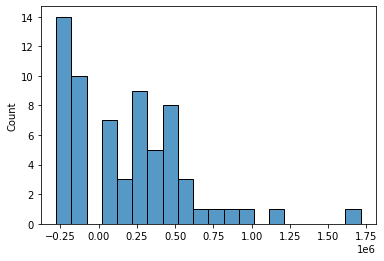

In [26]:
sns.histplot(zips, bins = 20);

The distribution of the zip codes skews right, with with most zip codes changing the sale price from about -\\$250,000 to \\$500,000 and a handfull of zip codes that raise the price of a home significantly up to \\$1,711,924.